In [1]:
# Standard library imports
import subprocess
import os
import json
import shutil

# Contributed library imports
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from pathlib import Path

# Set constants
You should be able to define most of the behavior from these constants

In [2]:
training_sites = ["chips", "delta"]

In [3]:
## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"

LONG_SITE_NAME_DICT = {"valley": "ValleyA", "chips": "ChipsB", "delta": "DeltaB"}

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

TRAINING_SITES_STR = "_".join(training_sites)

TRAINING_DATA_FOLDER = Path(
    PROJECT_ROOT,
    "models",
    "multi_site",
    TRAINING_SITES_STR,
)
AGGREGATED_LABELS_FOLDER = Path(TRAINING_DATA_FOLDER, "inputs", "labels")
AGGREGATED_IMAGES_FOLDER = Path(TRAINING_DATA_FOLDER, "inputs", "images")
WORK_DIR = Path(TRAINING_DATA_FOLDER, "work_dir")

In [4]:
# We need to merge all the imagery together
# I think this should be stored in the models folder, alongside the real models
# It should be as simple as creating the folders and symlinking the existing ones into it
Path(AGGREGATED_IMAGES_FOLDER).mkdir(exist_ok=True, parents=True)
Path(AGGREGATED_LABELS_FOLDER).mkdir(exist_ok=True, parents=True)

for training_site in training_sites:
    long_site_name = LONG_SITE_NAME_DICT[training_site]
    render_folder = Path(
        PROJECT_ROOT,
        "per_site_processing",
        training_site,
        "03_training_data",
        "renders",
    )
    images_near_labels_folder = Path(
        PROJECT_ROOT, "per_site_processing", training_site, "03_training_data", "images_near_labels"
    )
    output_render_folder = Path(AGGREGATED_LABELS_FOLDER, training_site)
    output_image_folder = Path(AGGREGATED_IMAGES_FOLDER, training_site)

    # Unlink if symlink
    output_render_folder.unlink(missing_ok=True)
    output_image_folder.unlink(missing_ok=True)
    # Remove if folder
    shutil.rmtree(output_render_folder, ignore_errors=True)
    shutil.rmtree(output_image_folder, ignore_errors=True)

    shutil.copytree(render_folder, output_render_folder)
    shutil.copytree(images_near_labels_folder, output_image_folder)

In [5]:
# Use one of the render folders, assuming they are all the same
IDs_to_labels_file = Path(render_folder, "IDs_to_labels.json")
with open(IDs_to_labels_file, "r") as infile:
    data = json.load(infile)

class_names = list(data.values())
class_names_str = " ".join(class_names)
print(class_names_str)

run_str = (
    f"{MMSEG_UTILS_PYTHON} {FOLDER_TO_CITYSCAPES_SCRIPT} --images-folder {AGGREGATED_IMAGES_FOLDER}"
    + f" --labels-folder {AGGREGATED_LABELS_FOLDER} --output-folder {TRAINING_DATA_FOLDER} --classes {class_names_str} --remove-old"
)
print(run_str)
subprocess.run(
    run_str,
    shell=True,
)

ABCO CADE PILA PIPO PSME QUEV SNAG
/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py --images-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/inputs/images --labels-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/inputs/labels --output-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta --classes ABCO CADE PILA PIPO PSME QUEV SNAG --remove-old


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


(3992372, 3)
mean: [110.07673157711757, 117.34348151925722, 98.32517160224548], std: [66.12795115416112, 64.67214420973849, 57.42558672904056]
About to save config to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/chips_delta.py


visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train: 100%|██████████| 38/38 [01:38<00:00,  2.59s/it]
visualizing to /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/val: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py --images-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/inputs/images --labels-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/inputs/labels --output-folder /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta --classes ABCO CADE PILA PIPO PSME QUEV SNAG --remove-old', returncode=0)

# Show some of the formatted example images

/tmp/ipykernel_8302/2317022773.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(cmap_file))


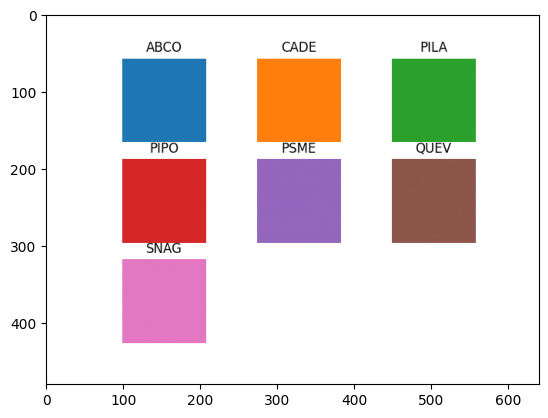

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_26_101MEDIA_DJI_0591_rgb.JPG


/tmp/ipykernel_8302/2317022773.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(file))


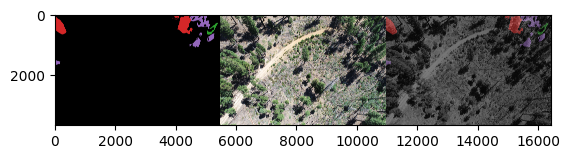

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/delta_DeltaB_80m_PART_03_104MEDIA_DJI_0224_rgb.JPG


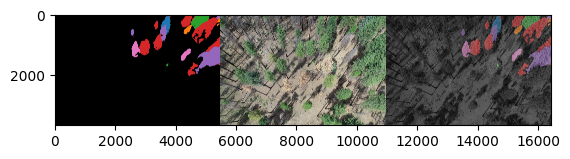

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0829_rgb.JPG


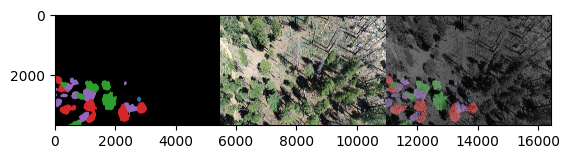

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/delta_DeltaB_80m_PART_03_102MEDIA_DJI_0737_rgb.JPG


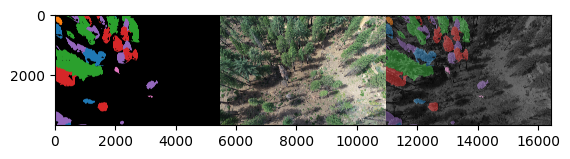

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/delta_DeltaB_80m_PART_03_102MEDIA_DJI_0568_rgb.JPG


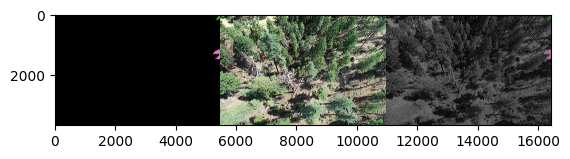

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0829_rgb.JPG


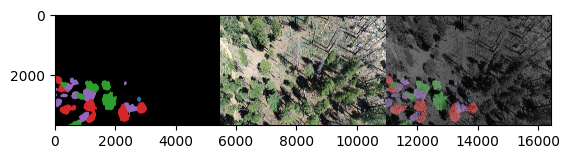

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/val/delta_DeltaB_80m_PART_01_104MEDIA_DJI_0184_rgb.JPG


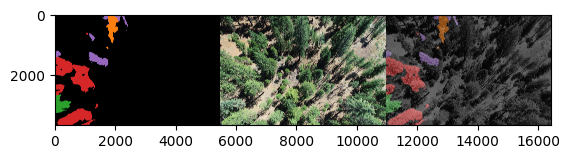

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/delta_DeltaB_80m_PART_03_104MEDIA_DJI_0224_rgb.JPG


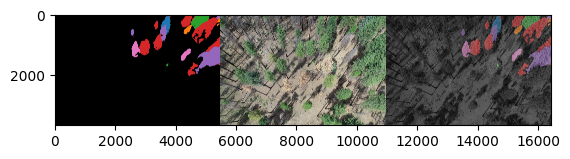

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/val/chips_ChipsB_80m_2021_complete_SD_card_25_103MEDIA_DJI_0936_rgb.JPG


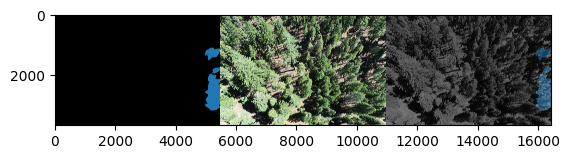

showing /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/vis/train/delta_DeltaB_80m_PART_02_104MEDIA_DJI_0587_rgb.JPG


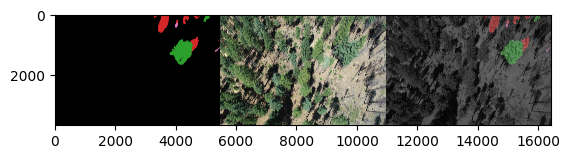

In [6]:
cmap_file = Path(TRAINING_DATA_FOLDER, "colormap.png")
plt.imshow(imread(cmap_file))
plt.show()

vis_folder = Path(TRAINING_DATA_FOLDER, "vis")
vis_files = list(vis_folder.rglob("*JPG"))
for file in np.random.choice(vis_files, 10):
    print(f"showing {file}")
    plt.imshow(imread(file))
    plt.show()

# Train a model

In [7]:
# Identify the config file as the only python file in the
config_file = list(Path(TRAINING_DATA_FOLDER).glob("*py"))[0]
subprocess.run(
    f"{MMSEG_PYTHON} {TRAIN_SCRIPT} {config_file} --work-dir {WORK_DIR}", shell=True
)

02/10 04:33:00 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1704039013
    GPU 0: GRID A100X-20C
    CUDA_HOME: /ofo-share/repos-david/conda/envs/MVMT-stable
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencod

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


02/10 04:33:11 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/10 04:33:11 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/ofo-share/repos-david/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:64: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn(


02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
02/10 04:33:14 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/train.py /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/chips_delta.py --work-dir /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/models/multi_site/chips_delta/work_dir', returncode=0)